<a href="https://colab.research.google.com/github/sunnnymskang/GANS_melanoma/blob/master/week1_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install torch
!pip install torchvision
!pip install NumPy
!pip install sklearn
!pip install matplotlib

Note that I've mostly referred and adapted from : https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

1. Data loading

In [58]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [59]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485,) , (0.229,))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485,) , (0.229,))
    ]),
}

In [60]:
image_datasets = {x: datasets.MNIST('PATH_TO_STORE_TRAINSET', train=y,transform=data_transforms[x],download=True) for x, y in {'train':True, 'val':False}.items()}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [62]:
device,class_names,dataset_sizes

(device(type='cuda', index=0),
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 {'train': 60000, 'val': 10000})

1a. Visualize the data points

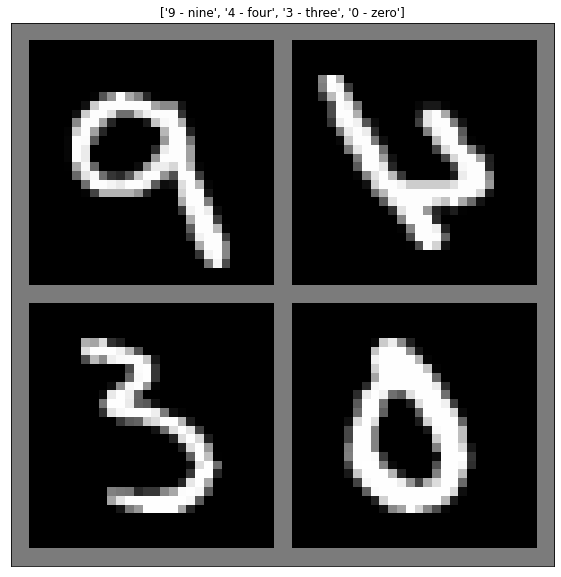

In [63]:
def imshow(inp, title=None, ax=None ):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(0.485,)
    std = np.array(0.229,)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if ax is None:
      fig, ax = plt.subplots(1)
    ax.imshow(inp)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
      ax.set_title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=2)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

2. NN model 

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        #print("before maxpool2d, conv1:{}".format(x.size()))
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        #print("After maxpool2d, conv1:{}".format(x.size()))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        #print("After maxpool2d, conv2:{}".format(x.size()))
        x = x.view(-1, self.num_flat_features(x))
        #print("Before Relu, fc1:{}".format(x.size()))
        x = F.relu(self.fc1(x))
        #print("Before Relu, fc2:{}".format(x.size()))
        x = F.relu(self.fc2(x))
        #print("Before Relu, fc3:{}".format(x.size()))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [65]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


3. Training the model 

In [66]:
#Schedule the learning rate and save the best model 

In [69]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #print("pass")
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [70]:
model_ft = train_model(net, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0185 Acc: 0.9946
val Loss: 0.0388 Acc: 0.9882

Epoch 1/9
----------
train Loss: 0.0183 Acc: 0.9948
val Loss: 0.0369 Acc: 0.9891

Epoch 2/9
----------
train Loss: 0.0178 Acc: 0.9947
val Loss: 0.0388 Acc: 0.9885

Epoch 3/9
----------
train Loss: 0.0153 Acc: 0.9957
val Loss: 0.0383 Acc: 0.9885

Epoch 4/9
----------
train Loss: 0.0156 Acc: 0.9954
val Loss: 0.0386 Acc: 0.9886

Epoch 5/9
----------
train Loss: 0.0155 Acc: 0.9958
val Loss: 0.0387 Acc: 0.9888

Epoch 6/9
----------
train Loss: 0.0150 Acc: 0.9957
val Loss: 0.0383 Acc: 0.9885

Epoch 7/9
----------
train Loss: 0.0151 Acc: 0.9957
val Loss: 0.0381 Acc: 0.9887

Epoch 8/9
----------
train Loss: 0.0151 Acc: 0.9960
val Loss: 0.0388 Acc: 0.9883

Epoch 9/9
----------
train Loss: 0.0157 Acc: 0.9956
val Loss: 0.0383 Acc: 0.9884

Training complete in 17m 53s
Best val Acc: 0.989100


4. Testing the model 

5. Visualization of the model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model)